### Importing required libaries

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from models.old_model import SiameseNetwork

from losses.euclidean import ContrastiveLoss
from losses.cosine import ContrastiveLossCosine

from utils.vis_utils import imshow, show_plot
from utils.other_utils import joinpath, SiameseNetworkDataset, SiameseNetworkDataset_for_test, get_dataset
from utils.other_utils import intersection


In [16]:
# Setup the path where images are located
PATH = r"H:\capstone_code\data\faces"


# Setup the number of channels in the image, 3 for color, 1 for monochrome
nchannel=1

# no of epoch
EPOCH = 25

In [17]:
# def imshow(img, text=None):
#     """
#     This is a helper function to show images
#     """
#     plt.figure()
#     npimg = img.numpy()
#     plt.axis("off")
#     if text:
#         plt.text(75, 8, text, style='italic',fontweight='bold',
#             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()    
                         
# def show_plot(iteration,loss):
#     """
#     This is a helper function to plot loss for any given run
#     """
#     plt.plot(iteration,loss)
#     plt.show()

It will read two images and return them, as well as their label. 
If they are in the same category, i.e. the same person, 
it will return 0, and otherwise, it will return 1.

In [18]:
# class SiameseNetworkDataset(Dataset):   
#     def __init__(self,imageFolderDataset,transform=None):
#         self.imageFolderDataset = imageFolderDataset    
#         self.transform = transform
        
#     def __getitem__(self,index):
#         img0_tuple = random.choice(self.imageFolderDataset.imgs)

#         #We need to approximately 50% of images to be in the same class
#         should_get_same_class = random.randint(0,1) 
#         if should_get_same_class:
#             while True:
#                 #Look untill the same class image is found
#                 img1_tuple = random.choice(self.imageFolderDataset.imgs) 
#                 if img0_tuple[1] == img1_tuple[1]:
#                     break
#         else:

#             while True:
#                 #Look untill a different class image is found
#                 img1_tuple = random.choice(self.imageFolderDataset.imgs) 
#                 if img0_tuple[1] != img1_tuple[1]:
#                     break

#         img0 = Image.open(img0_tuple[0])
#         img1 = Image.open(img1_tuple[0])
        
#         #Convert to grayscake
# #         img0 = img0.convert("L")
# #         img1 = img1.convert("L")

#         if self.transform is not None:
#             img0 = self.transform(img0)
#             img1 = self.transform(img1)
        
#         return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
#     def __len__(self):
#         return len(self.imageFolderDataset.imgs)

It will read one image at a time and return its label based on the folder it is present

In [19]:
# class SiameseNetworkDataset_for_test(Dataset):
#     def __init__(self,imageFolderDataset,transform=None):
#         self.imageFolderDataset = imageFolderDataset    
#         self.transform = transform
        
#     def __getitem__(self,index):
#         img0_tuple = self.imageFolderDataset.imgs[index] # one image
#         img0 = Image.open(img0_tuple[0])

#         # getting which classes represent which index
#         d = {v: k for k, v in self.imageFolderDataset.class_to_idx.items()}

#         # label returned with class name rather than class index
#         label = d.get(img0_tuple[1])


#         if self.transform is not None:
#             img0 = self.transform(img0)
        
#         return img0,label
    
#     def __len__(self):
#         return len(self.imageFolderDataset.imgs)

Initialize the dataset by calling the ImageFolderfunction and passing the path to the training set. 
Define a simple transformation of only a resize and transformation to tensors. 
Call  custom class and pass in the transformation, as well as the folder_dataset created at the top

In [20]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()])

In [21]:
# # Load the training dataset
# folder_dataset = datasets.ImageFolder(root=joinpath(PATH,'train'))


# # Initialize the network
# siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
#                                         transform=transformation)

For simple visualization purposes let’s look at this example.  
Create a DataLoader of the siamese_dataset and extract the first batch only.  
Combine each combination of images, because our siamese_datasetwill return two images and one label, and print out the labels.

In [22]:
os.cpu_count() #cpu count

16

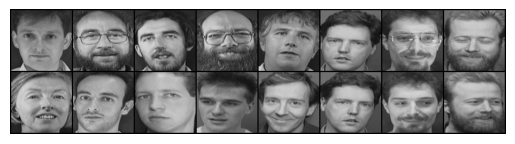

[1. 1. 1. 1. 1. 0. 0. 0.]


In [23]:
# Create a simple dataloader just for simple visualization
# vis_dataloader = DataLoader(siamese_dataset,
#                         shuffle=True,
#                         num_workers=0, # Number of CPU to engage
#                         batch_size=8)

vis_dataloader,_ = get_dataset(joinpath(PATH,'train'),transformation,SiameseNetworkDataset,0,8,True)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [24]:
# #create the Siamese Neural Network
# class SiameseNetwork(nn.Module):

#     def __init__(self):
#         super(SiameseNetwork, self).__init__()

#         # Setting up the Sequential of CNN Layers
#         self.cnn1 = nn.Sequential(
#             nn.Conv2d(nchannel, 96, kernel_size=11,stride=4),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
            
#             nn.Conv2d(96, 256, kernel_size=5, stride=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, stride=2),

#             nn.Conv2d(256, 384, kernel_size=3,stride=1),
#             nn.ReLU(inplace=True)
#         )

#         # Setting up the Fully Connected Layers
#         self.fc1 = nn.Sequential(
#             nn.Linear(384, 1024),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(1024, 256),
#             nn.ReLU(inplace=True),
            
#             nn.Linear(256,128)
#         )
# # we pass two images through the same network.
# # This forward_oncefunction, called inside the forwardfunction, will take an image as input and pass it into the network. 
# # The output is stored into output1and the output from the second image is stored into output2, as we can see in the forwardfunction. 
# # In this way, we have managed to input two images and get two outputs from our model.   
        
#     def forward_once(self, x):
#         # This function will be called for both images
#         # Its output is used to determine the similiarity
#         output = self.cnn1(x)
#         output = output.view(output.size()[0], -1)
#         output = self.fc1(output)
#         return output

#     def forward(self, input1, input2):
#         # In this function we pass in both images and obtain both vectors
#         # which are returned
#         output1 = self.forward_once(input1)
#         output2 = self.forward_once(input2)

#         return output1, output2
        


# ## New architecture, TODO: still in testing
# # class SiameseNetwork(nn.Module):
# #     def __init__(self):
# #         super(SiameseNetwork, self).__init__()
# #         # Setting up the Sequential of CNN Layers
# #         self.cnn1 = nn.Sequential(
# #             nn.Conv2d(nchannel, 96, kernel_size=5, stride=2,),
# #             nn.BatchNorm2d(96),
# #             nn.ReLU(inplace=True),
# #             nn.MaxPool2d(2, stride=2),

# #             nn.Conv2d(96, 256, kernel_size=3, stride=1),
# #             nn.BatchNorm2d(256),
# #             nn.ReLU(inplace=True),
# #             nn.MaxPool2d(2, stride=2),

# #             nn.Conv2d(256, 384, kernel_size=3, stride=1),
# #             nn.BatchNorm2d(384),
# #             nn.ReLU(inplace=True),

# #             nn.Conv2d(384, 512, kernel_size=1, stride=1),
# #             nn.BatchNorm2d(512),
# #             nn.ReLU(inplace=True),
# #             nn.MaxPool2d(2, stride=2),

# #             nn.Conv2d(512, 256, kernel_size=3, stride=1),
# #             nn.ReLU(inplace=True)

# #         )

# #         self.fc1 = nn.Sequential(

# #             nn.Linear(1024,2048),
# #             nn.ReLU(inplace=True),
# #             nn.Dropout(0.2),

            
# #             nn.Linear(2048, 1024),
# #             nn.ReLU(inplace=True),
# #             nn.Dropout(0.2),

# #             nn.Linear(1024, 256),
# #             nn.ReLU(inplace=True),
 
# #             nn.Linear(256,128)
# #         )
# #     def forward_once(self, x):
# #         x = self.cnn1(x)
# #         x = x.view(x.size()[0], -1)
# #         x = self.fc1(x)
# #         return x
# #     def forward(self, input1, input2):
# #         output1 = self.forward_once(input1)
# #         output2 = self.forward_once(input2)
# #         return output1, output2

### Contrastive Loss Function
How do we calculate the distance or the dissimilarity between these two vectors?

Let’s look at an example when both \(x^{(i)}\) and \(x^{(j)}\) are of the same person, I will denote these two images as \(A\) and \(B\). In this case, we want \(d\) to be a small value:

\(d(A, B) = ||f(A) – f(B)||^2\)

But, what happens when \(x^{(i)}\) and \(x^{(j)}\) are of different people, or a negative pair? Then the distance \(d\) should be large. In such a case, we will not apply the l2 distance norm, or distance function directly, but rather a hinge loss. Why is that?

We want to separate \(f(x^{(i)})\) and \(f(x^{(j)})\) if they are of different people, but we want to separate them until we hit a certain margin \(m\). The idea behind this, is that we don’t actually want to push \(f(x^{(i)})\) and \(f(x^{(j)})\) further and further apart if they are already far from the margin \(m\).

\(d(A, B) = max(0, m^2 – ||f(A) – f(B)||^2)\)

Now, we combine the two together and end up with a formula that is called the Contrastive Loss Function.

This function will calculate the similarity between the two vectors. As we mentioned earlier, the objective of the Siamese networks is not to classify, but rather to differentiate between the images. So a loss function like Cross-Entropy loss is not suitable for this problem.

The Contrastive Loss function evaluates how well the network distinguishes a given pair of images. The function is defined as follows:

\(L(A, B, Y) = (Y)*||f(A) – f(B)||^2 + (1-Y)*\{ max(0, m^2 – ||f(A) – f(B)||^2)\}\)

Looking at the equation at the top, \(Y\) here indicates the label. The label will be 1 if the two images are of the same person, and 0 if the images are of different persons.

The equation has two parts. One positive part, when the two images are of the same people, and one negative part, when the two images are of different people.

From left to right, the first part of the formula is the positive pair, we know when the two images are of the same person, our \(Y\) will be 1. We want to minimize the distance between these two embeddings when the two images are of the same person. So the first part of the equation will be used, but the second part will be ignored because \((1-Y)\) will equal to \(0\).

When we actually have a negative pair, \(Y\) is equal to 0, the left part is ignored and the second part is used. Here we apply the hinge loss, because of the reason mentioned above, and we separate our embeddings further and further away until we hit the margin \(M\).

The output of this equation will be the value that will indicate if the two images are of the same person or not, the same category or not.

This loss function is so to say, the most basic function for learning similarity. Still, even being the most basic, it can solve most of the similarity problems. 


In [25]:
# # Define the Contrastive Loss Function with Euclidean Distance
# class ContrastiveLoss(torch.nn.Module):
#     def __init__(self, margin=2.0):
#         super(ContrastiveLoss, self).__init__()
#         self.margin = margin

#     def forward(self, output1, output2, label):
#       # Calculate the euclidean distance and calculate the contrastive loss
#       euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

#       loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
#                                     (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


#       return loss_contrastive

In [26]:
# # Defining Contrastive loss with Cosine Similarity 
# class ContrastiveLossCosine(torch.nn.Module):
#     def __init__(self, margin=0.5):
#         super(ContrastiveLossCosine, self).__init__()
#         self.margin = margin
    
#     def forward(self, output1, output2, label):
#         cosine_sim = torch.cosine_similarity(output1, output2)
#         cosine_sim = 1 - cosine_sim
#         loss = torch.mean((1 - label) * torch.pow(cosine_sim, 2) + 
#                           label * torch.pow(torch.clamp(self.margin - cosine_sim, min=0.0), 2))
#         return loss

        

Now that we defined the loss function that we will use, our next step would be definining the data that we will use for the training, and create a data loader object. It will accept our siamese_datasetand also shuffle our data. We will set the num_workersto 8 and also the batch_size to 64.

We will also initialize our model, as well as the loss and optimizer.

In [27]:
# Load the training dataset
# train_dataloader = DataLoader(siamese_dataset,
#                         shuffle=True,
#                         num_workers=0,
#                         batch_size=64)

train_dataloader,_ = get_dataset(joinpath(PATH,'train'), transformation, SiameseNetworkDataset, 0, 64, True)
net = SiameseNetwork(nchannel).cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [28]:
print(net)

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
)


In [29]:
from torchsummary import summary
# summary(net, [(3, 100, 100), (3, 100, 100)])
summary(net, [(nchannel, 100, 100), (nchannel, 100, 100)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 23, 23]          11,712
              ReLU-2           [-1, 96, 23, 23]               0
         MaxPool2d-3           [-1, 96, 11, 11]               0
            Conv2d-4            [-1, 256, 7, 7]         614,656
              ReLU-5            [-1, 256, 7, 7]               0
         MaxPool2d-6            [-1, 256, 3, 3]               0
            Conv2d-7            [-1, 384, 1, 1]         885,120
              ReLU-8            [-1, 384, 1, 1]               0
            Linear-9                 [-1, 1024]         394,240
             ReLU-10                 [-1, 1024]               0
           Linear-11                  [-1, 256]         262,400
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
           Conv2d-14           [-1, 96,

Following the flow diagram from the top, we can start creating the training loop. We iterate 200 times and extract the two images as well as the label. We zero the gradients and pass our two images into the network, and the network outputs two vectors. The two vectors, and the label, are then fed into the criterion (loss function) that we defined. We backpropagate and optimize. For some visualization purposes and to see how our model is performing on the training set, so we will print the loss every 10 batches.

In [30]:
def train(epochs = EPOCH):

    counter = []
    loss_history = [] 
    iteration_number= 0

    # Iterate throught the epochs
    for epoch in range(epochs):

    # Iterate over batches
        for i, (img0, img1, label) in enumerate(train_dataloader, 0):

            # Send the images and labels to CUDA
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = net(img0, img1)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = criterion(output1, output2, label)

            # Calculate the backpropagation
            loss_contrastive.backward()

            # Optimize
            optimizer.step()

            # Every 10 batches print out the loss
            if i % 10 == 0 :
                print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
                iteration_number += 10

                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return (counter,loss_history)

Epoch number 0
 Current loss 1.8567217588424683

Epoch number 1
 Current loss 1.542387843132019

Epoch number 2
 Current loss 1.0581879615783691

Epoch number 3
 Current loss 1.0514708757400513

Epoch number 4
 Current loss 0.558803379535675

Epoch number 5
 Current loss 0.6544421911239624

Epoch number 6
 Current loss 0.5132447481155396

Epoch number 7
 Current loss 0.3660910129547119

Epoch number 8
 Current loss 0.5148946046829224

Epoch number 9
 Current loss 0.608026385307312

Epoch number 10
 Current loss 0.47962579131126404

Epoch number 11
 Current loss 0.4908643960952759

Epoch number 12
 Current loss 0.4578777253627777

Epoch number 13
 Current loss 0.4733361005783081

Epoch number 14
 Current loss 0.41532349586486816

Epoch number 15
 Current loss 0.2979215383529663

Epoch number 16
 Current loss 0.42527276277542114

Epoch number 17
 Current loss 0.4132198691368103

Epoch number 18
 Current loss 0.3294503092765808

Epoch number 19
 Current loss 0.25520628690719604

Epoch num

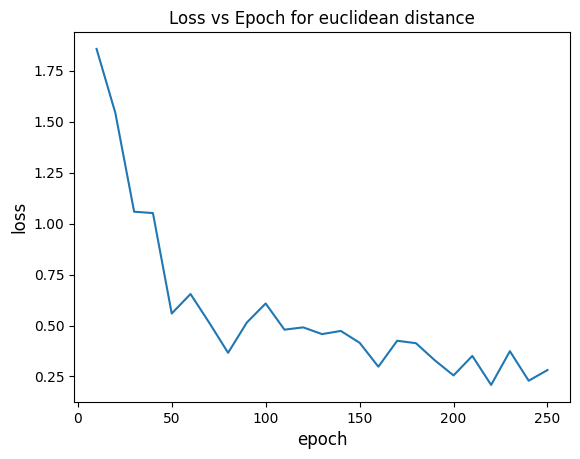

In [31]:
counter,loss_history = train(EPOCH)
# Plotting the loss vs epoch

plt.figure()
plt.title('Loss vs Epoch for euclidean distance')
plt.xlabel("epoch", fontsize=12)
plt.ylabel("loss", fontsize=12)
show_plot(counter, loss_history)

We can now analyze the results. The first thing we can see is that the loss started around 1.6 and ended at a number pretty close to 0.

It would be interesting to see the model in action. Now comes the part where we test our model on images it didn’t see before. As we have done before, we create a Siamese Network Dataset using our custom dataset class, but now we point it to the test folder.

As the next steps, we extract the first image from the first batch of the test set and iterate over all the train images to check how it performs.

We pass in the two images into the model and obtain two vectors, which are then passed into theF.pairwise_distance() function, this will calculate the euclidean distance between the two vectors. Using this distance, we can as a metric of how dissimilar the two faces are.

In [32]:
# def get_dataset(path,transforms,SiameseNetworkDataset,batch_size,shuffle):
#     folder_dataset = datasets.ImageFolder(root=path)
#     siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
#                                             transform=transforms)
#     dataloader = DataLoader(siamese_dataset, batch_size=batch_size, shuffle=shuffle)
#     return dataloader

In [34]:
#### here we create dataiter for test

# Locate the test dataset and load it into the SiameseNetworkDataset_for_test
test_dataloader,_ = get_dataset(joinpath(PATH,'test'), transformation, SiameseNetworkDataset_for_test, 0, 1, True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0,_ = next(dataiter)


#### here we create dataiter for train.

# Locate the test dataset and load it into the SiameseNetworkDataset_for_test
train_dataloader,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), transformation, SiameseNetworkDataset_for_test, 0, 1, False)

dataiter_train = iter(train_dataloader)

score = []

for i in range(len(siamese_dataset_train)):
    # Iterate over all images and test them with the first image (x0)
    x1,_ = next(dataiter_train)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    score.append(round(euclidean_distance.item(),2))
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
    # cosine_distance = torch.cosine_similarity(output1, output2)
    # score.append(round(cosine_distance.item(),2))
    # imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {cosine_distance.item():.2f}')

NameError: name 'siamese_dataset_train' is not defined

Now we test all the test images with all the train images and all combination are unique.

In [ ]:
#### here we create dataiter for test

# Locate the test dataset and load it into the SiameseNetworkDataset

folder_dataset_test = datasets.ImageFolder(root=joinpath(PATH,'test'))
siamese_dataset = SiameseNetworkDataset_for_test(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)

                                        
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=False)

#### here we create dataiter for train

# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_train = datasets.ImageFolder(root=joinpath(PATH,'train'))
siamese_dataset_train = SiameseNetworkDataset_for_test(imageFolderDataset=folder_dataset_train,
                                        transform=transformation)

                                        
train_dataloader = DataLoader(siamese_dataset_train, batch_size=1, shuffle=False)



truth=[]
predict=[]
same_disssimilarity=[]
different_disssimilarity=[]
count_label0 = []
count_label1 = []


dataiter = iter(test_dataloader)
for i in range(len(siamese_dataset)):
    
    x0,label0 = next(dataiter)
    count_label0.append(label0)
    

# Grab one image that we are going to test
    dataiter_train = iter(train_dataloader)

    for i in range(len(siamese_dataset_train)):
    # Iterate over 5 images and test them with the first image (x0)
        x1,label1 = next(dataiter_train)
        count_label1.append(label1)

        # Concatenate the two images together
        concatenated = torch.cat((x0, x1), 0)

        output1, output2 = net(x0.cuda(), x1.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        

        predict.append(euclidean_distance.item())
        if label0==label1: # if labels of two images are same append them to same_dissimilar
            same_disssimilarity.append(euclidean_distance.item())
        else:
            different_disssimilarity.append(euclidean_distance.item())

        # cosine_distance = torch.cosine_similarity(output1, output2)
        # predict.append(cosine_distance.item())
        # if label0==label1:
        #     same_disssimilarity.append(cosine_distance.item())
        # else:
        #     different_disssimilarity.append(cosine_distance.item())

In [ ]:
# checking if there are any intersection in same and different images

# intersection = []

# for i in same_disssimilarity:
#   if i > min(different_disssimilarity):
#     intersection.append(i)
# for j in different_disssimilarity:
#   if j < max(same_disssimilarity):
#     intersection.append(j)

print("Number of total interesection: ", len(intersection(same_disssimilarity,different_disssimilarity)))

In [ ]:
# #### Original code

# # Locate the test dataset and load it into the SiameseNetworkDataset
# # folder_dataset_test = datasets.ImageFolder(root="./Test_auto_parts/")
# folder_dataset_test = datasets.ImageFolder(root="data/face_grey_new/test")
# siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
#                                         transform=transformation)
# test_dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)




# # Grab one image that we are going to test
# dataiter = iter(test_dataloader)
# x0, _, _ = next(dataiter)
# # plt.figure()

# for i in range(10):
#     # Iterate over 5 images and test them with the first image (x0)
#     _, x1, label2 = next(dataiter)

#     # Concatenate the two images together
#     concatenated = torch.cat((x0, x1), 0)
    
#     output1, output2 = net(x0.cuda(), x1.cuda())
#     euclidean_distance = F.pairwise_distance(output1, output2)
#     imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

In [ ]:
# ### ALWAYS WORKS

# # %matplotlib widget
# # Create a simple dataloader just for simple visualization
# folder_dataset_test = datasets.ImageFolder(root="data/face_grey_new/test")
# siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
#                                         transform=transformation)
# vis_dataloader = DataLoader(siamese_dataset,
#                         shuffle=True,
#                         num_workers=0, # Number of CPU to engage
#                         batch_size=1)

# for i in range(1):
#     # Extract one batch
#     example_batch = next(iter(vis_dataloader))
#     x0, X1, label1=example_batch

#     # Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
#     # If the label is 1, it means that it is not the same person, label is 0, same person in both images
#     concatenated = torch.cat((example_batch[0], example_batch[1]),0)

#     imshow(torchvision.utils.make_grid(concatenated))
#     print(example_batch[2].numpy().reshape(-1))
#     print(label1)

In [ ]:
# # Locate the test dataset and load it into the SiameseNetworkDataset
# # folder_dataset_test = datasets.ImageFolder(root="./Test_auto_parts/")
# folder_dataset_test = datasets.ImageFolder(root="data/face_grey_new/test")
# siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
#                                         transform=transformation)
# test_dataloader = DataLoader(siamese_dataset_test, num_workers=2, batch_size=1, shuffle=True)

# # Grab one image that we are going to test
# truth=[]
# predict=[]
# same_disssimilarity=[]
# different_disssimilarity=[]

# for i in range(100):
#     example_batch = next(iter(test_dataloader))


#     # Concatenate the two images together

#     concatenated = torch.cat((example_batch[0], example_batch[1]),0)


#     output1, output2 = net(example_batch[0].cuda(), example_batch[1].cuda())
#     euclidean_distance = F.pairwise_distance(output1, output2)
# #     imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
# #     print(example_batch[2].numpy().reshape(-1))
#     truth.append(example_batch[2].numpy().reshape(-1).item())
#     predict.append(euclidean_distance.item())
#     if truth[i]==0:
#         same_disssimilarity.append(euclidean_distance.item())
#     if truth[i]==1:
#         different_disssimilarity.append(euclidean_distance.item())

In [ ]:
# Plotting the distribution for same vs dissimilar images density plot

%matplotlib widget
import seaborn as sns
import matplotlib.pyplot as plt

# Set custom color palette
colors = ["#E74C3C", "#3498DB"]

# Create figure and axes objects
fig, ax = plt.subplots(figsize=(8, 6))

# Set background color
ax.set_facecolor("#F7F7F7")

# Plot the distributions and set custom colors
sns.distplot(same_disssimilarity, bins=100, kde=True, hist=False, rug=False, label="Same", color=colors[0])
sns.distplot(different_disssimilarity, bins=100, kde=True, hist=False, rug=False, label="Different", color=colors[1])

# Add legend and title
plt.legend(fontsize=14)
plt.title('Density vs Dissimilarity for euclidean distance', fontsize=20)

# Add gridlines
ax.grid(linestyle='--', linewidth=0.5)

# Set axis labels and tick sizes
plt.xlabel("Dissimilarity", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Remove top and right spines
sns.despine(top=True, right=True)

plt.show()

In [ ]:
# checking for mean/average score

from statistics import mean
print("Mean of same images: ",mean(same_disssimilarity))
print("Mean of different images: ",mean(different_disssimilarity))

In [ ]:
# Prinitng total number of combinations that we tested on

print("Total number of combinations of same images: ", len(same_disssimilarity))
print("Total number of combinations of different images: ", len(different_disssimilarity))
print("Total number of combinations: ", len(same_disssimilarity) + len(different_disssimilarity))

In [ ]:
# Checking for number of missclassified images

final_list = []
same_misclassified = []
different_misclassified = []
score = 0.3
for s in same_disssimilarity:
    if s > score:
        final_list.append(s)
        same_misclassified.append(s)
for d in different_disssimilarity:
    if d <= score:
        final_list.append(d)
        different_misclassified.append(d)

print(len(final_list))
print(len(same_misclassified))
print(len(different_misclassified))

In [ ]:
# import seaborn as sns
# sns.distplot(intersection, bins=100, kde=True,hist=True, rug=True, label="intersection");
# plt.legend()
# plt.xlabel("Dissimilarity")
# plt.show()

In [ ]:
# folder_dataset_test = datasets.ImageFolder(root="./data/faces/train")
# siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
#                                         transform=transformation)
# test_dataloader = DataLoader(siamese_dataset_test, num_workers=2, batch_size=1, shuffle=True)

# # Grab one image that we are going to test
# truth2=[]
# predict2=[]
# same_disssimilarity2=[]
# different_disssimilarity2=[]

# for i in range(100):
#     example_batch = next(iter(test_dataloader))


#     # Concatenate the two images together

#     concatenated = torch.cat((example_batch[0], example_batch[1]),0)


#     output1, output2 = net(example_batch[0].cuda(), example_batch[1].cuda())
#     euclidean_distance = F.pairwise_distance(output1, output2)
# #     imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
# #     print(example_batch[2].numpy().reshape(-1))
#     truth2.append(example_batch[2].numpy().reshape(-1).item())
#     predict2.append(euclidean_distance.item())
#     if truth2[i]==0:
#         same_disssimilarity2.append(euclidean_distance.item())
#     if truth2[i]==1:
#         different_disssimilarity2.append(euclidean_distance.item())